In [ ]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import os
import scipy.signal as sgn
from tqdm import tqdm
from biosppy.signals import ecg
from scipy.interpolate import CubicSpline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from scipy.signal import cheby1, filtfilt, medfilt, decimate
import tensorflow as tf


In [2]:
# get the list of files to be processed
ecgs_df = pd.read_csv("1.0.0\\list", header=None, names=['id'])
# add filepaths so we can retrieve the files later on
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: str("apnea-ecg\\1.0.0\\" + x))
# divide the dataset into train and test dataset as per instrucctions in the data set
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

In [3]:
# display the first 5 entries
ecgs_df.head()

,id,filepath,dataset
0,a01,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
1,a02,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
2,a03,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
3,a04,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
4,a05,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train


In [4]:
# display number of training and testing samples
freq = ecgs_df['dataset'].value_counts()
print(freq)

train    35
test     35
Name: dataset, dtype: int64


In [5]:
# Load ECG signals from files
def load_ecg(file):
    """
    Load ECG data using the WFDB library and return the ECG signal and apnea labels.
    """
    # Load the ECG signal
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, extension="apn")

    # Extract the first signal channel (if multichannel)
    p_signal = record.p_signal[:, 0]
    
    # Extract annotation symbols ('A' for apnea, 'N' for normal)
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample


In [6]:
def downsample_signal(signal, original_fs, target_fs):
    """
    Downsample the signal to a lower frequency.
    Args:
        signal (array): The original ECG signal.
        original_fs (int): The original frequency of the signal.
        target_fs (int): The target frequency to downsample to.
    Returns:
        downsampled_signal (array): The downsampled ECG signal.
    """
    # Compute the decimation factor
    decimation_factor = int(original_fs / target_fs)
    
    # Apply decimation (downsampling)
    downsampled_signal = decimate(signal, decimation_factor, zero_phase=True)
    
    return downsampled_signal

In [7]:
# Adjusted Chebyshev Bandpass Filter
def apply_chebyshev_bandpass_filter(signal, lowcut=0.5, highcut=30, fs=100, order=4):
    """
    Apply a Chebyshev Type I bandpass filter to the ECG signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = cheby1(order, 0.05, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply Median Filter for Smoothing
def apply_median_filter(signal, kernel_size=3):
    """
    Apply a median filter to smooth the ECG signal.
    Kernel size of 3 is generally a good starting point.
    """
    return medfilt(signal, kernel_size)

# Apply Moving Average Filter
def apply_moving_average(signal, window_size=5):
    """
    Apply a simple moving average filter to smooth the ECG signal.
    """
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')


In [8]:
# Preprocess Function with Additional Noise Reduction
def preprocess_and_downsample(signal, original_fs, target_fs):
    # Step 1: Apply the Chebyshev bandpass filter (updated)
    filtered_signal = apply_chebyshev_bandpass_filter(signal, fs=original_fs)
    
    # Step 2: Apply median filter
    smoothed_signal = apply_median_filter(filtered_signal, kernel_size=5)
    
    # Step 3: Apply moving average filter for additional smoothing
    smoothed_signal = apply_moving_average(smoothed_signal, window_size=5)
    
    # Step 4: Downsample the filtered and smoothed signal
    downsampled_signal = downsample_signal(smoothed_signal, original_fs, target_fs)
    
    return downsampled_signal

In [9]:
# Compute autocorrelation to measure similarity of a segment
def autocorrelation(signal):
    """
    Compute the autocorrelation of a signal.
    """
    result = np.correlate(signal, signal, mode='full')
    return result[result.size // 2:]

In [10]:
# Function to eliminate noisy segments using autocorrelation-based similarity matrix
def eliminate_noisy_segments(signal, threshold=0.8):
    """
    Eliminate noisy segments based on autocorrelation similarity.
    """
    acf = autocorrelation(signal)
    similarity = np.dot(acf, acf) / (np.linalg.norm(acf) ** 2)
    
    # Keep segment if similarity is above the threshold
    if similarity >= threshold:
        return signal  
    return None  


In [11]:
# Save ECG segment as an image without grid and normalized
def save_ecg_as_image(signal, filename):
    """
    Save the ECG segment as an image after preprocessing.
    """
    plt.figure(figsize=(6, 3))  
    plt.plot(signal)
    plt.axis('off')  
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

In [12]:
# Function to generate ECG images with preprocessing
def generate_ecg_images(pts, num_sec, original_fs, target_fs, save_dir, start_index=0):
    for pt_index, pt in enumerate(pts[start_index:], start=start_index):
        print(f"Processing {pt} (file {pt_index + 1} of {len(pts)})")
        
        p_signal, atr_sym, atr_sample = load_ecg(pt)  
        base_filename = os.path.basename(pt).split('.')[0]

        for i, (sample, label) in enumerate(zip(atr_sample, atr_sym)):
            # Determine if this segment is apnea ('A') or normal ('N')
            label_dir = '1' if label == 'A' else '0'
            save_label_dir = os.path.join(save_dir, label_dir)
            if not os.path.exists(save_label_dir):
                os.makedirs(save_label_dir)

            # Generate the ECG signal segment
            start_idx = max(0, sample - num_sec * original_fs)
            end_idx = min(len(p_signal), sample + num_sec * original_fs)
            signal_segment = p_signal[start_idx:end_idx]

            

            # Save the signal as an image
            filename = f"{save_label_dir}/ecg_image_{base_filename}_{i}.png"
            if not os.path.exists(filename):
                # Preprocess the signal (filter, smooth, and downsample)
                final_signal = preprocess_and_downsample(signal_segment, original_fs, target_fs)
                save_ecg_as_image(final_signal, filename)
                print(f"Saved {filename}")
            else:
                print(f"File {filename} already exists, skipping.")

In [13]:
# Define the path to the Apnea-ECG dataset files
dataset_base_dir = "apnea-ecg/1.0.0/"

# Generate training ECG paths using a for loop with different counts for 'a', 'b', and 'c'
train_ecg_paths = []
test_ecg_paths = []

# 'a' prefix has 20 files, so it will go from a01.apn to a20.apn
for i in range(1, 21):
    train_ecg_paths.append(f"{dataset_base_dir}a{str(i).zfill(2)}")

# 'b' prefix has 5 files, so it will go from b01.apn to b05.apn
for i in range(1, 6):
    train_ecg_paths.append(f"{dataset_base_dir}b{str(i).zfill(2)}")

# 'c' prefix has 10 files, so it will go from c01.apn to c10.apn
for i in range(1, 11):
    train_ecg_paths.append(f"{dataset_base_dir}c{str(i).zfill(2)}")

# Generate testing ECG paths (e.g., x01.apn to x35.apn)
for i in range(1, 36):
    test_ecg_paths.append(f"{dataset_base_dir}x{str(i).zfill(2)}")

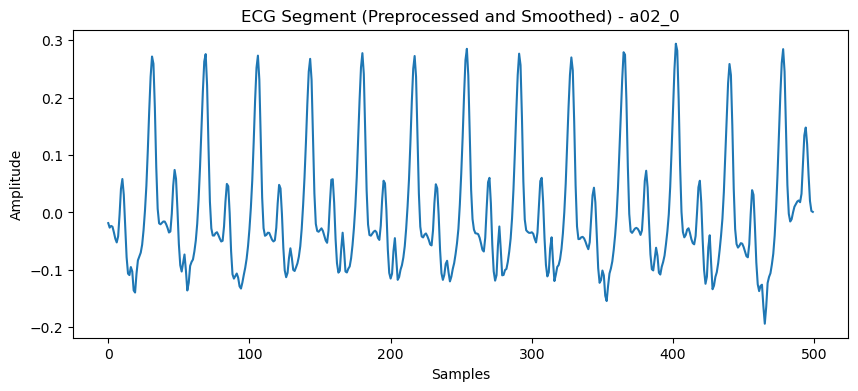

In [18]:
# Example plot to visualize the changes
def plot_example_ecg_segment(pt, num_sec=10, original_fs=100, target_fs=50):
    p_signal, atr_sym, atr_sample = load_ecg(pt)
    base_filename = os.path.basename(pt).split('.')[0]

    # Take the first segment as an example
    i = 0  # First segment for example
    sample = atr_sample[i]
    start_idx = max(0, sample - num_sec * original_fs)
    end_idx = min(len(p_signal), sample + num_sec * original_fs)
    signal_segment = p_signal[start_idx:end_idx]

    # Preprocess (filter and downsample) the signal with additional noise reduction
    clean_signal = preprocess_and_downsample(signal_segment, original_fs, target_fs)

    # Plot the clean, preprocessed signal
    if clean_signal is not None:
        plt.figure(figsize=(10, 4))
        plt.plot(clean_signal)
        plt.title(f"ECG Segment (Preprocessed and Smoothed) - {base_filename}_{i}")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()
    else:
        print(f"Segment {i} in file {base_filename} was identified as noisy and skipped.")

# Example: Plot the first ECG signal from your train dataset
example_pt = train_ecg_paths[1]  
plot_example_ecg_segment(example_pt)

In [14]:
# Paths for saving the filtered ECG images
filtered_train_dir = r"train_set"
filtered_test_dir = r"\test_set"

In [ ]:


# Create directories if they don't exist
os.makedirs(filtered_train_dir, exist_ok=True)
os.makedirs(filtered_test_dir, exist_ok=True)

# Set the original and target frequencies
original_fs = 100  
target_fs = 50  

# Generate images for the train and test ECG data
generate_ecg_images(train_ecg_paths, num_sec=10, original_fs=original_fs, target_fs=target_fs, save_dir=filtered_train_dir)
generate_ecg_images(test_ecg_paths, num_sec=10, original_fs=original_fs, target_fs=target_fs, save_dir=filtered_test_dir)

In [21]:
# # Define the model checkpoint
# checkpoint_path = "C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3/best_model.h5"
# checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=5,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     validation_split=0.2  
# )

# train_generator = train_datagen.flow_from_directory(
#     filtered_train_dir,
#     target_size=(128, 128),
#     batch_size=64,
#     class_mode='binary',
#     subset='training',
#     shuffle=True
# )

# val_generator = train_datagen.flow_from_directory(
#     filtered_train_dir,
#     target_size=(128, 128),
#     batch_size=64,
#     class_mode='binary',
#     subset='validation',
#     shuffle=True
# )
# # No augmentation for validation/test data
# val_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = val_datagen.flow_from_directory(
#     filtered_test_dir,
#     target_size=(128, 128),
#     batch_size=64,
#     class_mode='binary',
#     shuffle=False
# )
# Define the model checkpoint
checkpoint_path = "/best_model.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

from keras.preprocessing.image import ImageDataGenerator

# Set paths for the updated train and validation directories
train_new_dir = 'train_new'
validation_dir = 'validation'

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2]
)

# Train generator from new training directory
train_generator = train_datagen.flow_from_directory(
    train_new_dir,
    target_size=(128, 128),  # Adjust to your model input size
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

# Validation generator from the new validation directory
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),  # Adjust to your model input size
    batch_size=64,
    class_mode='binary',
    shuffle=True  # Ensure validation set is shuffled
)

# Test generator (remain unchanged, as this directory was not modified)
test_image_dir = 'test_set'
test_generator = val_datagen.flow_from_directory(
    test_image_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

# Now, you can continue using these generators in model training


Found 13612 images belonging to 2 classes.
Found 3433 images belonging to 2 classes.
Found 17268 images belonging to 2 classes.


In [22]:
# Callbacks: Reduce LR on plateau, EarlyStopping, Checkpoint
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Pass class weights into model.fit
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,  # Add class weights
    callbacks=[reduce_lr, early_stopping, checkpoint]
)


Epoch 1/20
213/213 [==============================] - ETA: 0s - loss: 2.1716 - accuracy: 0.5147
Epoch 1: val_loss improved from inf to 1.70123, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3\best_model.h5
213/213 [==============================] - 463s 2s/step - loss: 2.1716 - accuracy: 0.5147 - val_loss: 1.7012 - val_accuracy: 0.3822 - lr: 3.0000e-04
Epoch 2/20


C:\Users\abbas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 [==============================] - ETA: 0s - loss: 1.4306 - accuracy: 0.5308
Epoch 2: val_loss improved from 1.70123 to 1.23156, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3\best_model.h5
213/213 [==============================] - 458s 2s/step - loss: 1.4306 - accuracy: 0.5308 - val_loss: 1.2316 - val_accuracy: 0.3822 - lr: 3.0000e-04
Epoch 3/20
213/213 [==============================] - ETA: 0s - loss: 1.0930 - accuracy: 0.5820
Epoch 3: val_loss improved from 1.23156 to 1.01705, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3\best_model.h5
213/213 [==============================] - 475s 2s/step - loss: 1.0930 - accuracy: 0.5820 - val_loss: 1.0171 - val_accuracy: 0.6129 - lr: 3.0000e-04
Epoch 4/20
213/213 [==============================] - ETA: 0s - loss: 0.9374 - accuracy: 0.6167
Epoch 4: val_loss improved from 1.01705 to 0.96279, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apn

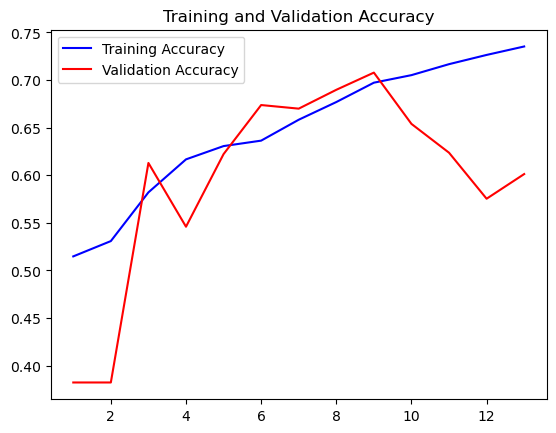

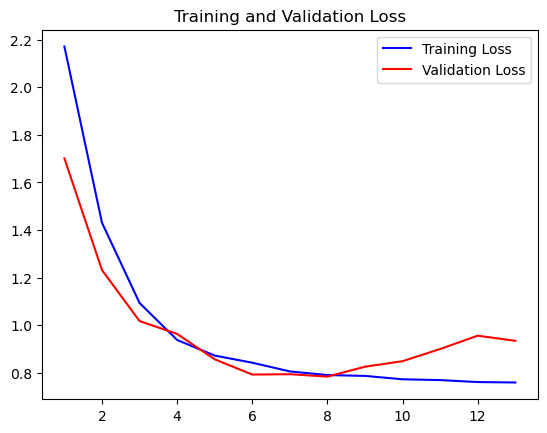

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure()
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()